In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import cmocean.cm as ocm
import seaborn as sns; sns.set()
import pandas as pd

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
int_dir = os.path.join(data_dir,'analysis','interim')
pro_dir = os.path.join(data_dir,'analysis','processed')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

In [2]:
grid_path = os.path.join(int_dir,'grd2_dV.nc')
u_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_u_avg.nc')
v_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_v_avg.nc')
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m_avg.nc')
sector_masks_path = os.path.join(int_dir,'mask_sector_2.npy') 
shelves_masks_path = os.path.join(int_dir,'shelves2.npy') 

grd = xr.open_dataset(grid_path)
u = xr.open_dataset(u_path).u.squeeze()
v = xr.open_dataset(v_path).v.squeeze()
temp = xr.open_dataset(temp_path).temp
salt = xr.open_dataset(salt_path).salt
m = xr.open_dataset(m_path).m
sector = np.load(sector_masks_path,allow_pickle=True).item()
shelves = np.load(shelves_masks_path,allow_pickle=True).item()

In [10]:
shelves['Abbot']['bathy_mean']

KeyError: 'bathy_mean'

In [4]:
avg = pd.DataFrame.from_dict(shelves).T[['ismr','lat','lon','A','Tm_front','Salt_front','sector','depth','tv4']].T

s2a = 3600*24*365.25

for row in ['lat','lon']:
    for k,item in avg.iteritems():
        avg[k][row] = item[row].mean()
        
for k,item in avg.iteritems():
    avg[k]['ismr'] = item['ismr']*s2a
    avg[k]['Tm_front'] = item['Tm_front'].values

In [13]:
avg['Abbot']

ismr                                               2.7082
lat                                              -72.7956
lon                                              -96.4683
A                                                 29.0229
Tm_front                              -0.7664164326168367
Salt_front                             34.170611812118096
sector                                       Amundsen Sea
depth                                 -235.77483978431812
tv4                                  0.022732858852395024
bathy_min     <xarray.DataArray 'h' ()>\narray(54.612967)
bathy_max          <xarray.DataArray 'h' ()>\narray(726.)
Name: Abbot, dtype: object

In [21]:
grd['zice']*=-1
grad = np.gradient(-grd.zice,10000)
magGradz = np.sqrt(grad[0]**2 + grad[1]**2)
gradz = xr.DataArray(magGradz,dims=('eta_rho','xi_rho'),name='gradz').where((grd.mask_rho==1)&(grd.zice>0))
gradz.name = 'gradZice'
grd['grad_zice'] = gradz

In [14]:

for k,v in log_progress(shelves.items(),every=2):
    for quant in ['h','zice','grad_zice']:
        avg[k][quant+'_mean'] = grd[quant].where(v['mask']).mean().values
        avg[k][quant+'_min'] = grd[quant].where(v['mask']).min().values
        avg[k][quant+'_max'] = grd[quant].where(v['mask']).max().values
        avg[k][quant+'_std'] = grd[quant].where(v['mask']).std().values

In [23]:
xi,eta = np.meshgrid(grd2.xi_rho,grd2.eta_rho)

In [103]:
x = [None  for x in range(grd2.xi_rho.size)]
x = np.broadcast_to(x,grd2.mask_rho.shape).astype('U15')
#mask_map = np.zeros_like(name_map)
for key,values in log_progress(shelves2.items(),every=2):
    x[values['mask']]=key
    #mask_map[values['mask']]=1
        
#mask_map = xr.DataArray(name_map,dims=('eta_rho','xi_rho')).where(mask_map)

In [113]:
grad = np.gradient(grd2.zice,10000)
magGradz = np.sqrt(grad[0]**2 + grad[1]**2)
gradz = xr.DataArray(magGradz,dims=('eta_rho','xi_rho'),name='gradz').where((grd2.mask_rho==1)&(grd2.zice<0))
gradz.name = 'gradZice'

In [115]:
shelves2['Abbot']['front_mask']

dict_keys(['lat', 'lon', 'eta', 'xi', 'mask', 'xi_mid', 'eta_mid', 'A', 'ismr', 'ismr_l', 'ismr_g', 'bmb', 'bml', 'bmg', 'ismr_max', 'ismr_min', 'sector', 'sector_color', 'Tdr', 'ustar', 'Tfr', 'Sfr', 'Tdr*ustar', 'Tfr*ustar', 'color', 'polyfit', 'r2', 'front_mask', 'Tm_front_shallow', 'Tm_front_deep', 'Tm_shallow', 'Tfr_shallow', 'ustar_shallow', 'Tb_shallow', 'TF_front_shallow', 'S_front_shallow', 'z_front_shallow', 'Tfr_front_shallow', 'Tdr_front_shallow', 'Tm_deep', 'Tfr_deep', 'ustar_deep', 'Tb_deep', 'TF_front_deep', 'S_front_deep', 'z_front_deep', 'Tfr_front_deep', 'Tdr_front_deep'])

In [118]:
melt = pd.DataFrame({'name':x.flatten(),'ismr':m2.values.flatten(),'eta':eta.flatten(),'xi':xi.flatten(),
                    'zice':grd2.zice.values.flatten(),'slope':gradz.values.flatten()}).dropna()
melt = melt.loc[melt['name']!='None']

In [119]:
for k,v in log_progress(shelves2.items(),every=2):
    melt.loc[(melt['name'] == k),'Tm_front_deep'] = v['Tm_front_deep']  
    melt.loc[(melt['name'] == k),'Tm_front_shallow'] = v['Tm_front_shallow']
    melt.loc[(melt['name'] == k),'Area'] = v['A']

In [120]:
melt.head()

,name,ismr,eta,xi,zice,slope,Tm_front_deep,Tm_front_shallow,Area
887361,Mertz,9.667372e-08,281,2211,-34.233284,0.008157,-1.813915,-1.690583,5.306813
890502,Mertz,7.683106e-08,282,2202,-64.209833,0.017577,-1.813915,-1.690583,5.306813
890503,Mertz,1.661513e-07,282,2203,-245.661830,0.014611,-1.813915,-1.690583,5.306813
890510,Mertz,7.896308e-08,282,2210,-26.103829,0.008872,-1.813915,-1.690583,5.306813
890511,Mertz,7.124099e-08,282,2211,-163.132831,0.009058,-1.813915,-1.690583,5.306813


In [124]:
from sklearn.linear_model import LinearRegression
melt.dropna(axis=0, how='any', inplace=True)
column_names = ['zice','slope','Tm_front_deep','Tm_front_shallow','Area']
X = melt[column_names]
y = melt['ismr']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
melt['predicted'] = model.predict(X)

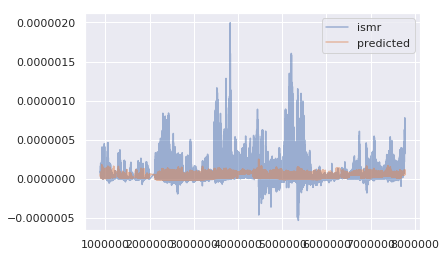

In [129]:
melt[['ismr','predicted']].plot(alpha=0.5)

In [130]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [131]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

NameError: name 'params' is not defined

In [59]:
for idx ,row in melt.iterrows():
    name = 

276.0
276.0
277.0
277.0
277.0
277.0
277.0
277.0
277.0
277.0
278.0
278.0
278.0
278.0
278.0
278.0
278.0
279.0
279.0
279.0
279.0
279.0
279.0
279.0
280.0
280.0
280.0
280.0
280.0
280.0
280.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
281.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
282.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
283.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
284.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
285.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
286.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.0
287.

301.0
301.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
302.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
303.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.0
304.

326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
326.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.0
327.

340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
340.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
341.0
342.0
342.0
342.0
342.

405.0
405.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
406.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
407.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
408.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
409.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
410.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
411.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
412.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.0
413.

496.0
496.0
496.0
496.0
496.0
496.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
497.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
498.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
499.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
500.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
501.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
502.0
503.0
503.

KeyboardInterrupt: 

In [49]:
melt.loc[(melt['eta'] == 276) & (melt['xi'] == 2024),'Tm_front_deep'] = 10

In [50]:
melt.head()

,ismr,eta,xi,Tm_front_deep
871424,7.383603e-08,276,2024,10.0
871425,6.678496e-08,276,2025,NaN
874570,6.874065e-08,277,2020,NaN
874571,5.488896e-08,277,2021,NaN
874572,4.619985e-08,277,2022,NaN
